# Post-Up Rate EDA and Model
In this notebook, I will explore the relationships of different player stats and their future post-up rate.  

Goals:
- Look for what stats might best predict post-up rate.
- Find the best model to make accurate predictions.

Conclusions: 
- This is easier to predict accurately than post-up expected value.
- This is harder to improve on the baseline (player performance in the current year)
- While the predictions were more accurate for rate than performance, the small sample size still seems to be a problem.

## 0. Importing Libraries and Data

In [32]:
# Importing standard libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Importing SKlearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, RFECV, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
# Importing created functions
from dictionaries import stat_types
from df_functions import use_history
from model_prep import corr_finder, data_split, feature_selection_corr, shift_data
from graphing import corr_plots, box_plots, graph_results

In [3]:
# Importing data
master_df = pd.read_csv('./data/master_df', index_col=0)

## 1. Create Train, Validate, and Test Sets
#### Create X and y

In [4]:
# Saving the data for all player seasons where they had at least 50 post-ups
post_index = master_df[(master_df['POST_TOUCHES'] * master_df['GP']) >= 50].index
data = master_df.loc[post_index]

In [5]:
# Matching player data with the target data in the following year
data = shift_data(data, 'PLAYER_ID', ['POST_TOUCH_RATE'])

In [6]:
# Setting up the initial X and y
y = data.loc[:, ['TARGET_POST_TOUCH_RATE']]
X = data.drop(columns='TARGET_POST_TOUCH_RATE')

#### Splitting X and y into train, validate, and test sets

In [7]:
# Creating the train, validate, and test sets for post-up expected value
X_train, X_validate, X_test, y_train, y_validate, y_test = data_split(X, y, 'POST_TOUCH_RATE')

## 2. Determine Potential Features
- The most correlated features seem to be plays that came from the post (post shots, post assists, closely guarded shots, etc.).

#### Finding correlated features

In [8]:
# Saving a list of possible numerical features
numeric_columns = list(data.dropna(axis=1).select_dtypes(['float', 'int']).columns)
numeric_columns.remove('TEAM_ID')
numeric_columns.remove('PLAYER_ID')
numeric_columns.remove('2018')

In [93]:
# Looking for features with the highest correlation with the target
corr_features = corr_finder(X_train[numeric_columns], y_train, .5, 10)

In [94]:
# Looking at the most correlated features with the target
corr_features

['POST_TOUCH_FGA_PER_MIN_WEIGHTED',
 'POST_TOUCH_RATE_WEIGHTED',
 'POST_TOUCH_FGA_PER_MIN',
 'POST_TOUCH_RATE',
 'POST_TOUCHES_PER_MIN_WEIGHTED',
 'POST_TOUCH_FGM_PER_MIN_WEIGHTED',
 'POST_TOUCH_PTS_PER_MIN_WEIGHTED',
 'POST_TOUCHES_PER_MIN',
 'POST_TOUCH_FGM_PER_MIN',
 'POST_TOUCH_FGA_WEIGHTED']

In [95]:
# Finding the most correlated features that are not correlated with each other
corr_features = feature_selection_corr(X_train[numeric_columns], y_train['TARGET_POST_TOUCH_RATE'], alpha=.5)

#### Graphing correlated features

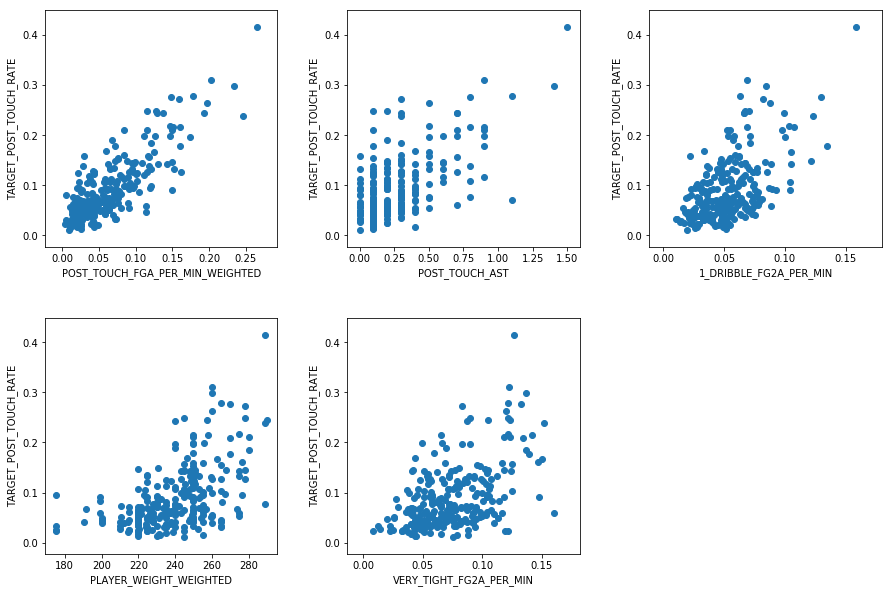

In [96]:
# Plotting those features
corr_plots(X_train, y_train, corr_features);

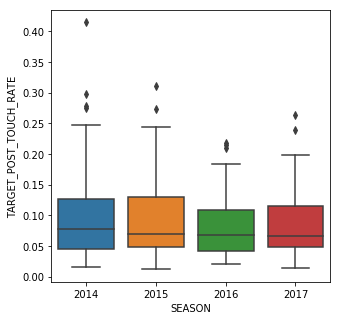

In [97]:
box_plots(X_train, y_train, ['SEASON'], cols=1)

## 3. Modeling

#### RFECV
- Used 13 features (many more than in the expected value for post-ups)

In [14]:
# Using recursive feature elimination to attempt to select features for the model
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True)
rfecv = RFECV(estimator=model, step=1, cv=kfolds)
rfecv.fit(X_train[numeric_columns], y_train.iloc[:,0])
rfecv.n_features_

13

In [15]:
# Checking which features were selected
X_train[numeric_columns].columns[rfecv.get_support(indices=True)]

Index(['DREB_CONTEST_PCT', 'PAINT_TOUCH_PTS_PCT', 'PAINT_TOUCH_TOV_PCT',
       'CATCH_SHOOT_EV', 'DREB_CHANCES_PER_MIN', 'DREB_CHANCE_DEFER_PER_MIN',
       'POST_TOUCH_PTS_PER_MIN', 'SKINNY', 'DREB_CONTEST_PCT_WEIGHTED',
       'PAINT_TOUCH_PTS_PCT_WEIGHTED', 'PAINT_TOUCH_AST_PCT_WEIGHTED',
       'CATCH_SHOOT_EV_WEIGHTED', 'SKINNY_WEIGHTED'],
      dtype='object')

In [16]:
# Checking out the score with the validation data
rfecv.score(X_validate[numeric_columns], y_validate)

0.6400466772310286

#### K BEST
- The 1 or 2 feature models seemed the best.
- As the features increased the model got worse.

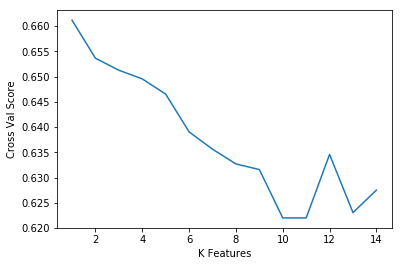

In [19]:
# Looping to select the best k for select k best feature selection
k_scores = []
for k in range(1, 15):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending cross val scores for those features
    model = LinearRegression()
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    k_scores.append(cross_val_score(model, X_train[model_features], y_train, cv=kfolds).mean())
    
plt.plot(range(1,15), k_scores)
plt.xlabel('K Features')
plt.ylabel('Cross Val Score');

1  Feature Cross Val Scores:  [0.63400277 0.63172173 0.76098812 0.53191496 0.74715392]
2  Feature Cross Val Scores:  [0.6430011  0.62422627 0.77011358 0.47868498 0.75213734]
3  Feature Cross Val Scores:  [0.63736144 0.62382846 0.76812636 0.47920676 0.74775953]
4  Feature Cross Val Scores:  [0.63786925 0.62465778 0.76793617 0.47515416 0.74210206]
5  Feature Cross Val Scores:  [0.63951501 0.60082939 0.77196044 0.47557723 0.74477358]
6  Feature Cross Val Scores:  [0.63867773 0.60194343 0.76679803 0.44283258 0.744992  ]
7  Feature Cross Val Scores:  [0.63008547 0.60303897 0.76425411 0.44060373 0.74014426]
8  Feature Cross Val Scores:  [0.62187933 0.5939501  0.76688451 0.43948674 0.7412953 ]


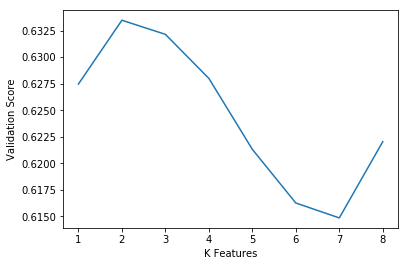

In [20]:
# Checking out 1 - 8 features
k_scores = []
for k in range(1, 9):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending the validation scores
    model = LinearRegression()
    model.fit(X_train[model_features], y_train)
    k_scores.append(model.score(X_validate[model_features], y_validate))
    
    # Printing out the cross val scores
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    print(k, ' Feature Cross Val Scores: ', cross_val_score(model, X_train[model_features], y_train, cv=kfolds))
    
# Graphing the validations scores
plt.plot(range(1, 9), k_scores)
plt.xlabel('K Features')
plt.ylabel('Validation Score');

In [28]:
# Printing out the scores with 2 features
k_best = SelectKBest(f_regression, k=2)
k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.6334716050425143

In [29]:
# Printing the model features
model_features

['POST_TOUCH_RATE_WEIGHTED', 'POST_TOUCH_FGA_PER_MIN_WEIGHTED']

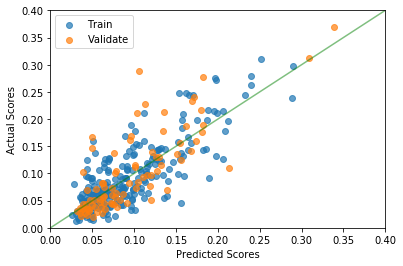

In [34]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=.4)

#### PCA
- The model does reasonably well, but one of the folds really struggled more than the others.
- 2 features were chosen using the elbow method.

In [215]:
# Fitting PCA and checking the explained variance
pca = PCA(n_components=15)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_validate_scaled = scaler.transform(X_validate[numeric_columns])
pca.fit(X_train_scaled)
explained_var = pca.explained_variance_ratio_
explained_var

array([0.28787183, 0.167387  , 0.06852191, 0.05595512, 0.0440408 ,
       0.02903332, 0.02747617, 0.0266557 , 0.01997668, 0.01708994,
       0.0155117 , 0.01278605, 0.01173434, 0.01142295, 0.00964497])

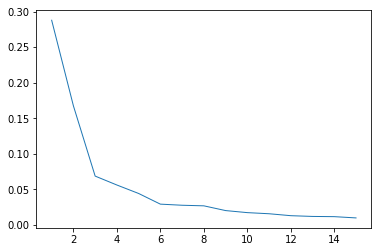

In [216]:
# Looking at the graph of explained variance and looking for the "elbow"
plt.plot(range(1, len(explained_var) + 1), explained_var, lw=1);

In [220]:
# Looking at the cross val score
pca = PCA(n_components=2)
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()
cross_val_score(model, pca.fit_transform(X_train_scaled), y_train, cv=kfolds)

array([0.43689767, 0.3444372 , 0.50809183, 0.0143293 , 0.51024408])

In [222]:
# Seeing the score on the validation set
model = LinearRegression()
model.fit(pca.transform(X_train_scaled), y_train)
model.score(pca.transform(X_validate_scaled), y_validate)

0.45068183704527964

#### Neural Net
- Higher predicted scores were generally too low.
- Performed much worse than other models.

In [38]:
# Preparing a neural net with all possible features
model_features = data[numeric_columns].dropna(axis=1).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [39]:
# Creating the neural net
model = Sequential()
model.add(Dense(len(model_features), activation='relu', input_dim=len(model_features)))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/2), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/4), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/8), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/16), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/32), activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(Dense(1, activation=None))

In [40]:
# Compiling the neural net and setting an early stopping feature
model.compile(loss='mean_squared_error', optimizer='adam')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50)

In [41]:
# Fitting the neural net
model.fit(X_train_scaled, y_train, validation_data=(X_validate_scaled, y_validate),epochs=1000,
          callbacks=[early], verbose=0);

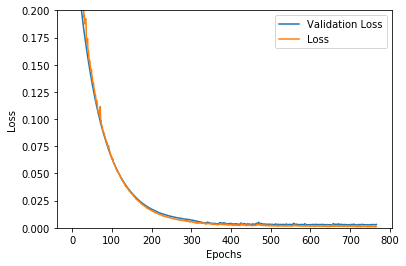

In [42]:
# Plotting the loss over epochs while training
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.plot(model.history.history['loss'], label='Loss')
plt.ylim(0,.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [43]:
# Finding the r2 score on the validation set
r2_score(y_validate, model.predict(X_validate_scaled))

0.46122200639669453

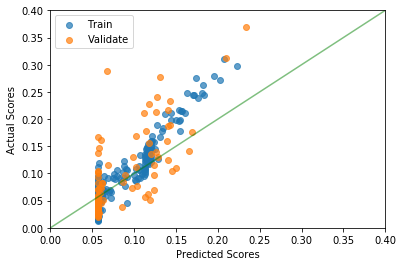

In [45]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, model, axis_max=.4)

#### Linear Regression with My Selected Features
- These features are based on correlations that I saw, features that go into post-up rate, and features that I wanted to experiment with.
- The scores seem similar to the better models.

In [181]:
# Saving the model features
model_features = ['FTA_PER_MIN_WEIGHTED', 'POST_TOUCHES_PER_MIN_WEIGHTED', 'POST_TOUCH_FGA_PCT', 
                  'POST_TOUCH_FGA_PCT', 'POST_TOUCH_TOV_PCT_WEIGHTED', 'CATCH_SHOOT_RATE_WEIGHTED',
                  'DRIVE_RATE_WEIGHTED', 'PULL_UP_RATE_WEIGHTED', 'PLAYER_HEIGHT_INCHES', 'SKINNY', 'AGE', '2015',
                  '2016', '2017', 'POST_TOUCH_RATE_WEIGHTED']

In [182]:
# Finding the cross validation score
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(model, X_train[model_features], y_train, cv=kfolds)

array([0.6456817 , 0.58310367, 0.77443472, 0.44514915, 0.75714846])

In [183]:
# Checking the validation scores
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.6242963598857774

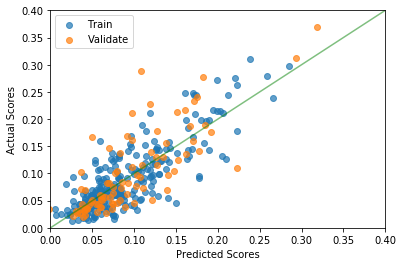

In [184]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=.4)

#### Regularized Linear Regression with My Selected Features
- These scores are slightly improved compared to the linear regression.
- The ridge scores are slightly better and its graph is very well balanced.

In [185]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [186]:
# Testing out ridge regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_cv = RidgeCV(alphas=np.logspace(-1,3,100), cv=kfolds)
ridge_cv.fit(X_train_scaled, y_train)
ridge = Ridge(alpha=ridge_cv.alpha_)
cross_val_score(ridge, X_train_scaled, y_train, cv=kfolds)

array([0.63859436, 0.60417582, 0.77726932, 0.45615261, 0.7448852 ])

In [187]:
# Seeing the score on the validation set
ridge.fit(X_train_scaled, y_train)
ridge.score(X_validate_scaled, y_validate)

0.630160269245017

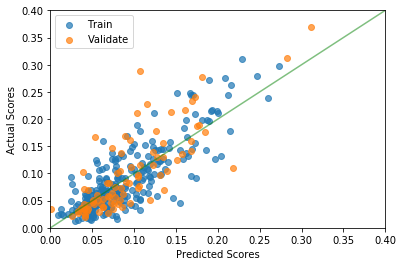

In [188]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, ridge, axis_max=.4)

In [189]:
# Testing out lasso regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_cv = LassoCV(alphas=np.linspace(.01,1,100), cv=kfolds)
lasso_cv.fit(X_train_scaled, y_train)
lasso = Lasso(alpha=lasso_cv.alpha_)
cross_val_score(lasso, X_train_scaled, y_train, cv=kfolds)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.61326968, 0.60284028, 0.74789366, 0.4609467 , 0.69075632])

In [190]:
# Seeing the score on the validation set
lasso.fit(X_train_scaled, y_train)
lasso.score(X_validate_scaled, y_validate)

0.593869782401278

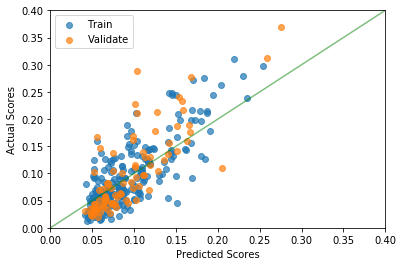

In [191]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, lasso, axis_max=.4)

In [192]:
# Looking at the selected features
lasso_coefs = pd.DataFrame(lasso.coef_, index=model_features, columns=['LASSO'])
ridge_coefs = pd.DataFrame(ridge.coef_, columns=model_features, index=['RIDGE']).T
pd.concat([lasso_coefs, ridge_coefs], axis=1)

,LASSO,RIDGE
FTA_PER_MIN_WEIGHTED,0.000000,0.000355
POST_TOUCHES_PER_MIN_WEIGHTED,0.000000,0.022165
POST_TOUCH_FGA_PCT,0.000000,0.002783
POST_TOUCH_FGA_PCT,0.000000,0.002783
POST_TOUCH_TOV_PCT_WEIGHTED,0.000000,0.001309
CATCH_SHOOT_RATE_WEIGHTED,0.000000,0.003318
DRIVE_RATE_WEIGHTED,-0.000000,0.002341
PULL_UP_RATE_WEIGHTED,-0.000000,-0.003025
PLAYER_HEIGHT_INCHES,0.000000,0.001603
SKINNY,-0.000000,-0.004805


#### Final scores (Ridge)
- The r2 score on the test set was similar to the best model scores on the validation sets.
- There was a 1.5 percent decline in the rmse compared to the baseline using the test set.
- There was a 6.5 percent improvement in the rmse compared to the baseline for the validation data.

In [193]:
# R2 score (test set)
# X_test_scaled = scaler.transform(X_test[model_features])
r2_score(y_test, model.predict(X_test[model_features]))

0.6498476161965837

In [197]:
# Root mean squared error (test set)
rmse = mean_squared_error(y_test, model.predict(X_test[model_features])) ** .5
rmse

0.040164949219072175

In [198]:
# The score if the prediction was just the value from the current year (test set)
baseline = mean_squared_error(y_test, X_test['POST_TOUCH_RATE']) ** .5
baseline

0.03956030073255104

In [199]:
# Looking at the percent improvement (test set)
1 - rmse/baseline

-0.01528422371227367

In [202]:
# Root mean squared error (validation data)
rmse = mean_squared_error(y_validate, model.predict(X_validate[model_features])) ** .5
rmse

0.04536164306367286

In [203]:
# The score if the prediction was just the value from the current year
baseline = mean_squared_error(y_validate, X_validate['POST_TOUCH_RATE']) ** .5
baseline

0.048534040473167755

In [204]:
# Percent improvement (validations)
1 - rmse/baseline

0.06536437886824542

#### Looking to correct the undervaluing/overvaluing problem (Future)

In [205]:
# Creating a training set
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
train['PREDICTED_POST_TOUCH_RATE'] = model.predict(X_train[model_features])

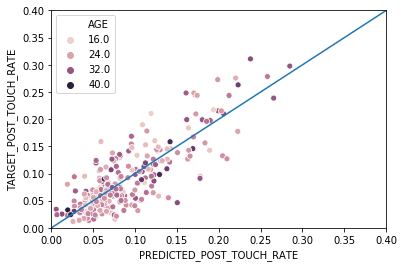

In [206]:
sns.scatterplot('PREDICTED_POST_TOUCH_RATE', 'TARGET_POST_TOUCH_RATE', data=train, hue='AGE')
plt.plot([0,.4], [0,.4])
plt.xlim(0, .4)
plt.ylim(0, .4);